<img src="../figures/fluxml.png" width=400 height=140>

# Working with Flux
In this part of the tutorial, we will show how to work with the Neural Network library called `Flux.jl`. Flux works in a similar way to PyTorch, but is fully built in Julia. It also supports the NVIDIA CUDA GPU backend, and other backends (`AMD`, `Metal`) are actively in development. This Notebook outlines the basic functionality of Flux using the MNIST dataset.

In [1]:
using Flux, Statistics
using MLJ: partition
using Plots
using MLDatasets: MNIST

After loading our libraries, we proceed to load the dataset.

In [2]:
data = MNIST(:train, dir="../datasets")

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

We split off a test set for real time overfitting monitoring, using the MLJ partition function.

In [3]:
train_idx, test_idx = partition(1:length(data.targets), 0.8, rng=123);

We define the training and testing features and labels. We add a dimension to the features to transform the images from (28x28) to (28x28x1), making them work with 2D convolutions.

In [4]:
train_ft = data.features[:,:,train_idx];
train_ft = reshape(train_ft, (size(train_ft, 1), size(train_ft, 2), 1, size(train_ft, 3)))
train_lb = data.targets[train_idx];

test_ft = data.features[:,:,test_idx];
test_ft = reshape(test_ft, (size(test_ft, 1), size(test_ft, 2), 1, size(test_ft, 3)))
test_lb = data.targets[test_idx];

We define the model using a chain of convolutions, max-pooling operations, a dropout layer and a dense layer to finalize the predictions.

In [13]:
# define the network
model = Chain(
  Conv((3,3), 1 => 12, relu),
  MaxPool((2,2)),
  Conv((3,3), 12 => 24, relu),
  MaxPool((2,2)),
  Conv((3,3), 24 => 48, relu),
  MaxPool((2,2)),
  Dropout(0.2),
  Flux.flatten,
  Dense(48 => 10)
)

Chain(
  Conv((3, 3), 1 => 12, relu),          # 120 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 12 => 24, relu),         # 2_616 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 24 => 48, relu),         # 10_416 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Flux.flatten,
  Dense(48 => 10),                      # 490 parameters
)                   # Total: 8 arrays, 13_642 parameters, 54.875 KiB.

We see that our model contains 13,642 parameters that can be trained. Now we convert our labels to one-hot format, and define a dataloader for training on the images in batches.

In [6]:
train_targets = Flux.onehotbatch(train_lb, 0:9)
test_targets = Flux.onehotbatch(test_lb, 0:9)
train_sources = Flux.DataLoader((train_ft, train_targets), batchsize = 20_000, shuffle = true)

3-element DataLoader(::Tuple{Array{Float32, 4}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=20000)
  with first element:
  (28×28×1×20000 Array{Float32, 4}, 10×20000 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

Setup the optimizer. We selected Adam with a learning rate of 0.01 for this example.

In [7]:
optim = Flux.setup(Flux.Adam(0.01), model);

Perform the train loop, while saving the losses and test losses to check for overfitting behavior. 

**Warning**: This block can easily take up to 30 minutes to run.

In [8]:
losses = []
val_losses = []

for epoch in 1:20
  if epoch % 2 == 0
    println("Epoch $(epoch)\n\tLoss: $(losses[end])\n\tTest Loss: $(val_losses[end])\n")
  end
  epoch_loss = []
  for (x, y) in train_sources
    loss, grads = Flux.withgradient(model) do m
      ŷ = m(x)
      Flux.logitcrossentropy(ŷ, y)
    end
    Flux.update!(optim, model, grads[1])
    push!(epoch_loss, loss)
  end
  
  ŷ_val = model(test_ft)
  val_loss = Flux.logitcrossentropy(ŷ_val, test_targets)
  push!(losses, mean(epoch_loss))
  push!(val_losses, val_loss)
end

#gif(anim, "../figures/losscurve.gif", fps=5)

Epoch 2
	Loss: 2.27897
	Test Loss: 2.1610935



Epoch 4
	Loss: 1.4822559
	Test Loss: 0.95761377



Epoch 6
	Loss: 0.81905776
	Test Loss: 0.5772222



Epoch 8
	Loss: 0.5859837
	Test Loss: 0.39168856



Epoch 10
	Loss: 0.43784252
	Test Loss: 0.28471595



Epoch 12
	Loss: 0.3542919
	Test Loss: 0.2280229



Epoch 14
	Loss: 0.2931049
	Test Loss: 0.19243355



Epoch 16
	Loss: 0.24965803
	Test Loss: 0.17043787



Epoch 18
	Loss: 0.2230231
	Test Loss: 0.14846373



Epoch 20
	Loss: 0.20022975
	Test Loss: 0.13595696



Finally, we can visualize our training curves, showing no overfitting behavior.

┌ Info: Saved animation to /Users/max/TUe/Julia-sysbio-workshop/figures/losscurve.gif
└ @ Plots /Users/max/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/Users/max/TUe/Julia-sysbio-workshop/figures/losscurve.gif")
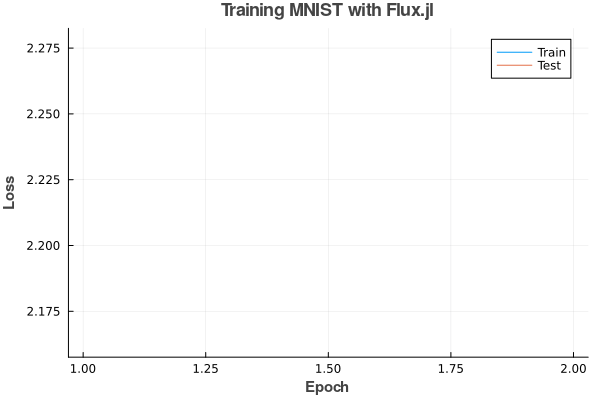

In [12]:
anim = @animate for epoch in 1:20
  pl = plot(losses[1:epoch], xlabel="Epoch", ylabel="Loss", title="Training MNIST with Flux.jl",
  titlefontfamily="Helvetica Bold", titlefontsize=12, guidefontfamily="Helvetica Bold", guidefontsize=10,
  label="Train")
  plot!(val_losses[1:epoch], label="Test")
end

gif(anim, "../figures/losscurve.gif", fps=3)